# BLU06 - Learning Notebook - Part 1 of 3 - Time Series Regression Problem Formulation

In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import utils

plt.rcParams['figure.figsize'] = (12, 4.2)

![](https://i.imgflip.com/2acblw.jpg)

As promised in the last BLU, we'll teach you how to use linear regression for time series forecasting. We have already done that a little when using the exogenous regressors with the ARIMA models. We can of course use exogenous features for time series regression as well, given that we can count on having the forecasts for them. Additionally, we can use features that are available in advance, like date related features and features created from the past values of the time series.

As a reminder, the linear regression fits a linear combination of features to the target, so the predicted values are

$$ \hat{y} = \beta_0 + \beta_1 x_1 + ... + \beta_n x_n$$

where $\hat{y}$ is the predicted value of the target, $x_i$ are the features and $\beta_i$ are the coefficients of the model.

So let's go, accompanied with the friendly airlines data.

## 1. One-step forecast with linear regression
Let's load the data and separate it into the train and test set (last two years).

In [2]:
airlines = utils.load_airlines_series()
airlines.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: thousands of passengers, dtype: int64

In [3]:
airlines_train = airlines.iloc[:-24]
airlines_test = airlines.iloc[-24:]

### 1.1 Problem formulation and next period forecast
If you remember how we learned regression back in SLU07, we had a dataframe with some columns as features and another column that was the target, the value we want to predict. This is what we're going to do now.

In one-step forecasting for the next timepoint, our target is the next value of the time series, so we'll make a target column with the time series shifted by one month. But first we'll create some features.

We learned with the ARIMA models that previous values are useful to predict future values, so we'll create a couple of lags as features.

In [4]:
data_one_step = pd.DataFrame(airlines_train) # we will need a dataframe to add feature columns
data_one_step['lag_1'] = airlines_train.shift(1)
data_one_step['lag_2'] = airlines_train.shift(2)

We also create a target which will be the next month's values of the time series.

In [5]:
data_one_step['target'] = airlines_train.shift(-1)

Behold. 

In [6]:
data_one_step.tail(4)

,thousands of passengers,lag_1,lag_2,target
Month,,,,
1958-09-01,404,505.0,491.0,359.0
1958-10-01,359,404.0,505.0,310.0
1958-11-01,310,359.0,404.0,337.0
1958-12-01,337,310.0,359.0,NaN


We have three feature columns, `thousands of passengers`, `lag_1`, and `lag_2`, and a target column with the future values of the time series.

With this, we can train on the current and lagged values of the time series and predict the next month's data. This is the basic problem formulation. 

Let's try to predict the next month using a super-basic [vanilla](https://youtu.be/rog8ou-ZepE?t=58s) [Linear Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [7]:
# what's the dumbest, simplest model I can think of? 
lr_one_step = LinearRegression()

We're always going to keep the last row of the data as input for calculating the model prediction and train the model on the rest of the training data. 

The last row contains the current value and the two previous timepoints. This is quite similar to forecasting in ARIMA models where we used the last few timepoints to calculate the following values. The target value for this row should be the number of passengers for the following month, Jan 1959, the first value in the test set. So using this row as input for model prediction should give us a forecast for this month. 

We also remove the first two rows with NaN values created by the `shift` from the train set.

In [8]:
last_period = data_one_step.iloc[-1:]
train_one_step = data_one_step.iloc[:-1].dropna()

In [9]:
train_one_step.tail()

,thousands of passengers,lag_1,lag_2,target
Month,,,,
1958-07-01,491,435.0,363.0,505.0
1958-08-01,505,491.0,435.0,404.0
1958-09-01,404,505.0,491.0,359.0
1958-10-01,359,404.0,505.0,310.0
1958-11-01,310,359.0,404.0,337.0


In [10]:
last_period

,thousands of passengers,lag_1,lag_2,target
Month,,,,
1958-12-01,337,310.0,359.0,NaN


Then we split the train set into X and y and feed it to the model.

In [11]:
feature_columns = ['thousands of passengers','lag_1','lag_2']
X_train_one_step = train_one_step[feature_columns]
y_train_one_step = train_one_step['target']

lr_one_step.fit(X_train_one_step, y_train_one_step)

LinearRegression()

So what would this model predict for the next month, Jan 1959?

In [12]:
lr_one_step.predict(last_period[feature_columns])

array([353.20749742])

We don't care too much about how good is this forecast at the moment, we'll work on that later. Let's look at the model coefficients to understand how the model uses the features. We'll make a small function for that.

In [13]:
def explain_linear_regression(lr, features):

    beta_0 = lr.intercept_
    betas = lr.coef_
    print('Regression: \n%0.3f' % beta_0)
    for b,f in zip(betas, features): 
        print('+ %0.3f * %s' % (b, f))

In [14]:
explain_linear_regression(lr_one_step, feature_columns)

Regression: 
14.245
+ 1.313 * thousands of passengers
+ -0.556 * lag_1
+ 0.192 * lag_2


Makes sense, the current timestep is the most important one to predict the next timestep. Similar to what we saw in the autocorrelation plot in the previous BLU.

### 1.2 Add more features and prepare the toolkit
We know from the last BLU that the data has a 12 period seasonality. Maybe we should include more lags into our train set. We're going to do just that and also create functions to prepare the data that we can reuse later.

This function creates new features from lags of the original data.

In [15]:
def build_lagged_features(df_, original, num_lags): 
    """
    Adds new features to df from lags of the original time series.
    """
    df_ = df_.copy()
    for i in range(1, num_lags+1):
        df_['lag_%s' % str(i)] = original.shift(i)      
    return df_

As mentioned, we'll add lags 1 to 11 of the original time series as features. With the current value, we'll have twelve.

In [16]:
data_more_features = pd.DataFrame(airlines_train)
data_more_features = build_lagged_features(data_more_features, airlines_train, 11)

In [17]:
data_more_features.head()

,thousands of passengers,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
Month,,,,,,,,,,,,
1949-01-01,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-02-01,118,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-03-01,132,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-04-01,129,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-05-01,121,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Beautiful! Next we make a function that creates a target with future values of the original time series.

In [18]:
def build_target(df, original, num_periods_ahead, target='target'):
    """ 
    Adds a target to df by shifting the original data from the future.
    """
    df_ = df.copy()
    df_[target] = original.shift(-num_periods_ahead)
    return df_

We add a target from one month in the future.

In [19]:
data_more_features = build_target(data_more_features, airlines_train, 1)

In [20]:
data_more_features.head()

,thousands of passengers,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,target
Month,,,,,,,,,,,,,
1949-01-01,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118.0
1949-02-01,118,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132.0
1949-03-01,132,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.0
1949-04-01,129,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.0
1949-05-01,121,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135.0


Perfect, the data's ready, we can proceed with the training. We'll make another function to separate the last row, get rid of the null values created by the shifting, and prepare the features and the target.

In [21]:
def prepare_train_set(df, target='target'): 
    """ 
    Separates the last period from the train set,
    drops null values, and prepares the features and the target for the model.
    """
    # anything that isn't a target is a feature
    features = [col for col in df.columns if col != target]
    last_period = df.iloc[-1:][features]
    train = df.iloc[:-1].dropna()
    X_train = train[features]
    y_train = train[target]
    return X_train, y_train, last_period

In [22]:
X_train, y_train, last_period = prepare_train_set(data_more_features)

Let's check that everything looks good. This is the X and y train side by side:

In [23]:
pd.concat([X_train, y_train], axis=1).tail()

,thousands of passengers,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,target
Month,,,,,,,,,,,,,
1958-07-01,491,435.0,363.0,348.0,362.0,318.0,340.0,336.0,305.0,347.0,404.0,467.0,505.0
1958-08-01,505,491.0,435.0,363.0,348.0,362.0,318.0,340.0,336.0,305.0,347.0,404.0,404.0
1958-09-01,404,505.0,491.0,435.0,363.0,348.0,362.0,318.0,340.0,336.0,305.0,347.0,359.0
1958-10-01,359,404.0,505.0,491.0,435.0,363.0,348.0,362.0,318.0,340.0,336.0,305.0,310.0
1958-11-01,310,359.0,404.0,505.0,491.0,435.0,363.0,348.0,362.0,318.0,340.0,336.0,337.0


This is the last row of the data that we reserved for calculating next month's forecast:

In [24]:
last_period

,thousands of passengers,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
Month,,,,,,,,,,,,
1958-12-01,337,310.0,359.0,404.0,505.0,491.0,435.0,363.0,348.0,362.0,318.0,340.0


Now the model:

In [25]:
lr_more_features = LinearRegression()
lr_more_features.fit(X_train, y_train)
lr_more_features.predict(last_period)

array([372.77845223])

Looking at the feature importances, you'll see that the most important feature is lag 11 (12 months before the forecast) and the current value.

In [26]:
explain_linear_regression(lr_more_features, X_train.columns)

Regression: 
13.805
+ 0.510 * thousands of passengers
+ -0.297 * lag_1
+ 0.226 * lag_2
+ -0.294 * lag_3
+ 0.323 * lag_4
+ -0.279 * lag_5
+ 0.275 * lag_6
+ -0.360 * lag_7
+ 0.299 * lag_8
+ -0.279 * lag_9
+ 0.369 * lag_10
+ 0.534 * lag_11


So that's great, we can forecast one period ahead pretty nicely.

![](https://i.imgflip.com/2akdo8.jpg)

At this point, we have two options. We can either

1. take the prediction we've just made, feed it as truth into the model, and predict again. This is like multi-step forecasting in ARIMA models.
2. Just train the model to predict one timepoint several periods in advance. 

With the first strategy, prediction errors will accumulate, making it a bad stategy as we try to predict further into the future. As such, we will try the second one.

### 1.3 One-step forecast for n months in advance
We'll start by making another function which will prepare our data for prediction using the workflow defined above. We basically put all the above defined functions into one.

In [27]:
def prepare_data_for_modeling(original, num_periods_ahead, num_lags, target='target'):
    """ 
    Prepare data for modeling.
    """
    df_ = pd.DataFrame(original)
    df_ = build_lagged_features(df_, original, num_lags)
    df_ = build_target(df_, original, num_periods_ahead, target=target)
    X_train, y_train, last_period = prepare_train_set(df_, target=target)
    return X_train, y_train, last_period

Let's use the function to get the X and y train and the last period for predicting two months ahead with 11 lags.

In [28]:
X_train, y_train, last_period = prepare_data_for_modeling(airlines_train, num_periods_ahead=2, num_lags=11)

This is just to see X and y train side by side to check that everything is fine.

In [29]:
pd.concat([X_train, y_train], axis=1).tail()

,thousands of passengers,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,target
Month,,,,,,,,,,,,,
1958-06-01,435,363.0,348.0,362.0,318.0,340.0,336.0,305.0,347.0,404.0,467.0,465.0,505.0
1958-07-01,491,435.0,363.0,348.0,362.0,318.0,340.0,336.0,305.0,347.0,404.0,467.0,404.0
1958-08-01,505,491.0,435.0,363.0,348.0,362.0,318.0,340.0,336.0,305.0,347.0,404.0,359.0
1958-09-01,404,505.0,491.0,435.0,363.0,348.0,362.0,318.0,340.0,336.0,305.0,347.0,310.0
1958-10-01,359,404.0,505.0,491.0,435.0,363.0,348.0,362.0,318.0,340.0,336.0,305.0,337.0


And the last period which is now two months away from the train set. The target value for this should be two months in the future, so Feb 1959, the second value in the test set.

In [30]:
last_period

,thousands of passengers,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
Month,,,,,,,,,,,,
1958-12-01,337,310.0,359.0,404.0,505.0,491.0,435.0,363.0,348.0,362.0,318.0,340.0


Great! Fit it!

In [31]:
# weeeee 
lr_2_ahead = LinearRegression()
lr_2_ahead.fit(X_train, y_train);
lr_2_ahead.predict(last_period)

array([342.61799079])

This is a different model than above, so the coefficients are also different. The most important value is lag 10, again 12 months before the forecast date.

In [32]:
explain_linear_regression(lr_2_ahead, X_train.columns)

Regression: 
17.781
+ 0.362 * thousands of passengers
+ -0.191 * lag_1
+ 0.091 * lag_2
+ -0.103 * lag_3
+ 0.109 * lag_4
+ -0.095 * lag_5
+ 0.082 * lag_6
+ -0.220 * lag_7
+ 0.198 * lag_8
+ -0.111 * lag_9
+ 1.260 * lag_10
+ -0.360 * lag_11


## 2. Multi-step Forecasting 

Currently we know how to predict one timepoint some periods into the future. We can actually do multi-step forecasting by building one model for each step. The functions below implement this, so take some time to understand them.

In [33]:
def forecast_period_n(original, model, num_periods_ahead, num_lags):
    """
    One-step forecast for n periods ahead.
    """
    X_train, y_train, last_period = prepare_data_for_modeling(original, 
                                                        num_periods_ahead=num_periods_ahead, 
                                                        num_lags=num_lags, target='target')
    model.fit(X_train, y_train)
    return model.predict(last_period)[0]

In [34]:
def multistep_forecast(original, model, num_periods_ahead, num_lags): 
    """
    Multi-step forecast for 1 to n periods ahead.
    """
    forecast = []
    for period_ahead in range(1, num_periods_ahead+1):
        pred = forecast_period_n(original=original, 
                                model=model, 
                                num_periods_ahead=period_ahead, 
                                num_lags=num_lags)
        
        forecast.append(pred)
    return forecast

Yep. Now let's forecast the whole two years of the test data, 24 periods.

In [35]:
forecast_24_periods=multistep_forecast(airlines_train, model=LinearRegression(), num_periods_ahead=24, num_lags=11)

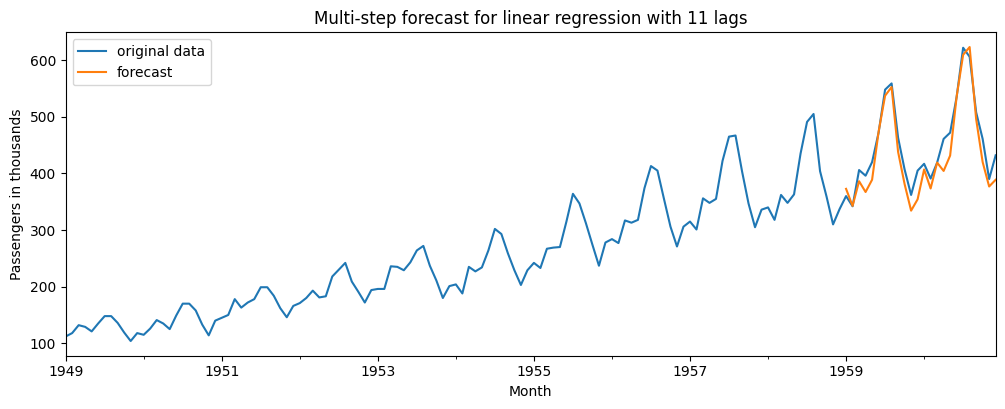

In [36]:
airlines.plot(label="original data")
plt.ylabel('Passengers in thousands')
plt.xlabel('Time')
pd.Series(forecast_24_periods, index=airlines_test.index).plot(label="forecast")
plt.title('Multi-step forecast for linear regression with 11 lags')
plt.legend();

In [37]:
mean_absolute_error(airlines_test,forecast_24_periods)

21.049607954553966

The MAE for SARIMAX one-step forecast was about 12 in the last BLU, so this is not bad. Still, it clearly isn't up to SARIMAX level. Remember that this is a well behaved time series that is quite simple and doesn't have a lot of data. This means it's a great use case for SARIMAX, so it's normal that a simple linear regression doesn't really beat it.

Here we used the lagged features to care of seasonality, we'll see other ways how to transmit seasonality information to the model in the next notebook.